<a href="https://colab.research.google.com/github/jrgee/CMPE297-98/blob/master/LeNet_and_VGG16_for_Cats_and_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and file loading


In [2]:
# updates tensorflow to 2.0
!pip install tensorflow-gpu

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from os import path
if not(path.exists('train')):
    print('Unzipping files')
    !unzip -q '/content/drive/My Drive/297-98/train.zip'
    print('finished train')
    !unzip -q '/content/drive/My Drive/297-98/val.zip'
    print('finished val')
else:
    print('Already loaded')

Unzipping files
finished train
finished val


In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time

from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


# Models

In [0]:
def build_lenet():
    model = keras.Sequential()

    model.add(Conv2D(filters=6, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=2, activation = 'softmax'))

    return model

In [0]:
def build_vggnet():
    model = keras.Sequential()

    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    # added batch norm to keep weights down
    model.add(Dense(units=4096))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(Dense(units=4096))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(Dense(units=2, activation="softmax"))

    return model



# Load data

In [8]:
BATCH = 32

imagegen = ImageDataGenerator(rescale=1./255)

train_lenet = imagegen.flow_from_directory(directory='/content/train',
                                           batch_size=BATCH, target_size=(32,32))
val_lenet = imagegen.flow_from_directory(directory='/content/val',
                                         batch_size=BATCH, target_size=(32,32))

train_vgg = imagegen.flow_from_directory(directory='/content/train',
                                         batch_size=BATCH, target_size=(224,224))
val_vgg = imagegen.flow_from_directory(directory='/content/val',
                                       batch_size=BATCH, target_size=(224,224))

Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.
Found 22778 images belonging to 2 classes.
Found 2222 images belonging to 2 classes.


In [9]:
print('# of batches in test set: ' + str(len(train_vgg)))

# of batches in test set: 712


In [0]:
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# LeNet

In [0]:
tf.keras.backend.clear_session()

opt = Adam(lr=0.001)

lenet = build_lenet()
lenet.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d (AveragePo (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               69240     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [0]:
start = time.time()
lenet_history = lenet.fit_generator(generator=train_lenet, epochs=10, steps_per_epoch=len(train_lenet), 
                                    validation_data=val_lenet, validation_steps=len(val_lenet), callbacks=[early])

print('took ' + str((time.time()-start)/60) + ' minutes')

Epoch 1/10
356/356 [==============================] - 73s 206ms/step - loss: 0.8660 - accuracy: 0.6215 - val_loss: 0.6228 - val_accuracy: 0.6746
Epoch 2/10
356/356 [==============================] - 71s 201ms/step - loss: 0.5996 - accuracy: 0.6761 - val_loss: 0.5997 - val_accuracy: 0.6877
Epoch 3/10
356/356 [==============================] - 71s 200ms/step - loss: 0.5599 - accuracy: 0.7124 - val_loss: 0.5790 - val_accuracy: 0.7030
Epoch 4/10
356/356 [==============================] - 72s 201ms/step - loss: 0.5251 - accuracy: 0.7389 - val_loss: 0.5728 - val_accuracy: 0.7124
Epoch 5/10
356/356 [==============================] - 71s 201ms/step - loss: 0.4872 - accuracy: 0.7646 - val_loss: 0.5604 - val_accuracy: 0.7138
Epoch 6/10
356/356 [==============================] - 71s 201ms/step - loss: 0.4453 - accuracy: 0.7883 - val_loss: 0.5938 - val_accuracy: 0.7183
Epoch 7/10
356/356 [==============================] - 72s 201ms/step - loss: 0.4028 - accuracy: 0.8130 - val_loss: 0.6250 - val_ac

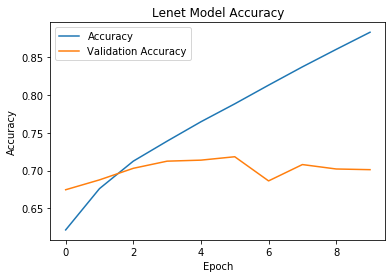

In [0]:
plt.plot(lenet_history.history["accuracy"])
plt.plot(lenet_history.history['val_accuracy'])
plt.title("Lenet Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

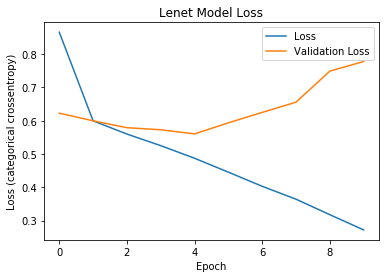

In [0]:
plt.plot(lenet_history.history['loss'])
plt.plot(lenet_history.history['val_loss'])
plt.title("Lenet Model Loss")
plt.ylabel("Loss (categorical crossentropy)")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

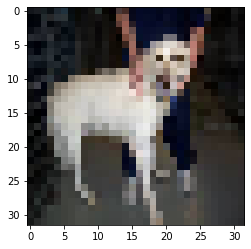

In [0]:
img_path = '/content/val/dog/dog.812.jpg'
img = image.load_img(img_path, target_size=(32,32))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)
# output = lenet.predict(img)
# print('% cat: ' + str(output[0][0]))
# print('% dog: ' + str(output[0][1]))

# VGGNet

In [11]:
tf.keras.backend.clear_session()

opt = Adam(lr=0.005)

vgg = build_vggnet()
vgg.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 256)       0

In [12]:
start = time.time()
vgg_history = vgg.fit_generator(generator=train_vgg, epochs=10, steps_per_epoch=len(train_vgg), 
                                validation_data=val_vgg, validation_steps=len(val_vgg), callbacks=[early])
print('took ' + str((time.time()-start)/60) + ' minutes')

Epoch 1/10
712/712 [==============================] - 552s 775ms/step - loss: 1.1036 - accuracy: 0.5425 - val_loss: 0.7287 - val_accuracy: 0.5333
Epoch 2/10
712/712 [==============================] - 532s 747ms/step - loss: 0.6882 - accuracy: 0.5972 - val_loss: 0.6899 - val_accuracy: 0.5617
Epoch 3/10
712/712 [==============================] - 532s 747ms/step - loss: 0.6483 - accuracy: 0.6297 - val_loss: 0.7445 - val_accuracy: 0.6251
Epoch 4/10
712/712 [==============================] - 532s 747ms/step - loss: 0.6086 - accuracy: 0.6696 - val_loss: 1.2051 - val_accuracy: 0.5644
Epoch 5/10
712/712 [==============================] - 530s 744ms/step - loss: 0.5580 - accuracy: 0.7121 - val_loss: 0.5697 - val_accuracy: 0.6962
Epoch 6/10
712/712 [==============================] - 528s 742ms/step - loss: 0.5115 - accuracy: 0.7497 - val_loss: 0.5178 - val_accuracy: 0.7439
Epoch 7/10
712/712 [==============================] - 528s 742ms/step - loss: 0.4730 - accuracy: 0.7745 - val_loss: 0.5181 -

In [0]:
# tf.keras.backend.clear_session()

# imagenet_vgg = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
# imagenet_vgg.trainable = False

# imagenet_vgg = keras.Sequential([imagenet_vgg,
#                                  Flatten(),
#                                  Dense(units=1024,activation="relu",),
#                                  BatchNormalization(),
#                                  Dense(units=512,activation="relu",),
#                                  BatchNormalization(),
#                                  Dense(units=2,activation="softmax",),
#                                 ])

# imagenet_vgg.summary()

# opt = Adam(lr=0.001)
# imagenet_vgg.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# start = time.time()
# vgg_history = imagenet_vgg.fit_generator(generator=train_vgg, epochs=100, steps_per_epoch=100, 
#                                 validation_data=val_vgg, validation_steps=len(val_vgg), callbacks=[early])
# print('took ' + str((time.time()-start)/60) + ' minutes')

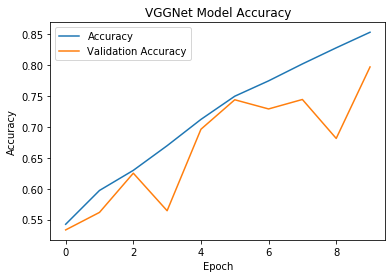

In [13]:
plt.plot(vgg_history.history["accuracy"])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("VGGNet Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

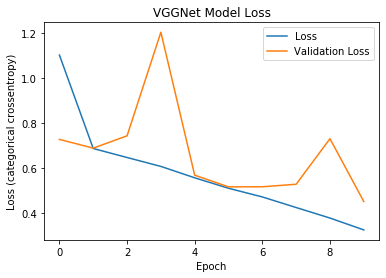

In [14]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("VGGNet Model Loss")
plt.ylabel("Loss (categorical crossentropy)")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

% cat: 1.0
% dog: 0.0


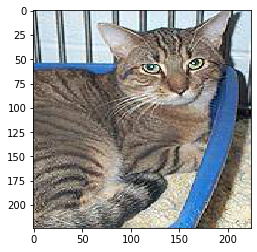

In [28]:
img_path = '/content/val/cat/cat.9834.jpg'
img = image.load_img(img_path, target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)

img = np.expand_dims(img, axis=0)
img = img.astype(np.float32)

output = vgg.predict(img)
print('% cat: ' + str(output[0][0]))
print('% dog: ' + str(output[0][1]))